# Simulation 

##### With the completion of our demand forecast, we will now use these forecasts as the basis for simulating demand.
In addition, we will introduce lead time as a variable, which often carries significant uncertainty and impacts critical outcomes such as stockouts, overstocking, and revenue.
The lead time will be simulated based on the statistical properties of historical lead time data (e.g., mean, standard deviation, or empirical distribution).
Through this simulation, we aim to test an ROP policy to determine how this policy influences stockouts and overstocks for each demand scenario.

## 1. Demand data


##### This is a forecast-based simulation, and as such, we will not use the historical demand distribution, which assumes stationary demand.
Instead, our forecasted demand accounts for trend and seasonality, resulting in a moving mean — where each forecasted value represents the expected demand at a specific time point.

To introduce randomness into the simulation, we incorporate forecast uncertainty, estimated by the discrepancy between actual and predicted values in the training data.
This discrepancy is captured by the standard deviation of the model's residuals, which we use to simulate realistic variability around each forecast.




In [8]:
import pandas as pd 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#load dataset
dataset = pd.read_csv('Historical Product Demand.csv')

# Load the model
with open('hot_winters_weekly_model.pkl', 'rb') as f:
    model = pickle.load(f)

# We will perform a simulation for category_019
model = model['Category_019']


In [12]:
# Preparing our forecast error to simulate randomness.
residuals = model.resid
resid_std = residuals.std()

In [36]:
import pandas as pd

# Number of steps to forecast 
num_steps = 10

# Get forecasted values
forecast = model.forecast(steps=num_steps)

# Set the last date of the training data 
last_date = pd.to_datetime('2015-01-05')

# Generate future weekly dates 
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=num_steps, freq='W-MON')

forecast.index = forecast_index

print(forecast)


2015-01-12    1.578132e+07
2015-01-19    1.550094e+07
2015-01-26    1.578132e+07
2015-02-02    1.550094e+07
2015-02-09    1.578132e+07
2015-02-16    1.550094e+07
2015-02-23    1.578132e+07
2015-03-02    1.550094e+07
2015-03-09    1.578132e+07
2015-03-16    1.550094e+07
Freq: W-MON, dtype: float64


/opt/miniconda3/envs/DataEngineeringProjects/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/DataEngineeringProjects/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


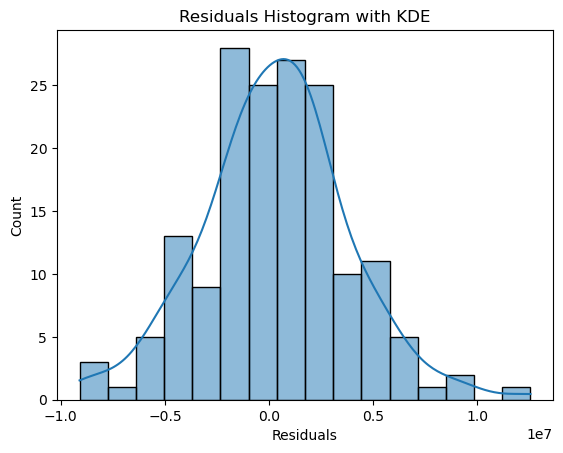

In [49]:
#validating the residuals distribution 
sns.histplot(residuals, kde=True)
plt.title("Residuals Histogram with KDE")
plt.xlabel("Residuals")
plt.show()

##### As we can see above the residual follows a normal distribution, as should any effective model's 
##### residual that has properly captured the patterns in the data, we will proceed to using it 
##### simulating our demand using a normal distribuion with a the standard deviation as the std 
##### of the residuals 


### 1a. Generating probabilistic forecast 

In [38]:
seed = 42  # Choose any integer seed
np.random.seed(seed)
N = 1000
# Simulating the demand 
sim_demand = [forecast + np.random.normal(loc = 0 , scale = resid_std, size = len(forecast)) for _ in range(N)]
Weeks = ['Week_1','Week_2','Week_3','Week_4','Week_5','Week_6','Week_7','Week_8','Week_9','Week_10']
Week_forecast = {week:[] for week in Weeks}

for path in sim_demand:
    for i , week in enumerate(Weeks):
       Week_forecast[week].append(path[i]) 

In [39]:
# Calculate statistics for each week
for week, forecast_list in Week_forecast.items():
    lower_bound = np.percentile(forecast_list, 5)
    upper_bound = np.percentile(forecast_list, 95)
    expected_value = np.mean(forecast_list)
    
    print(f"For {week}:")
    print(f"  🔹 Expected demand: {round(expected_value, 2)}")
    print(f"  🔹 90% Confidence Interval: [{round(lower_bound, 2)}, {round(upper_bound, 2)}]")
    print("-" * 50)

For Week_1:
  🔹 Expected demand: 15819101.92
  🔹 90% Confidence Interval: [9852704.06, 21670317.47]
--------------------------------------------------
For Week_2:
  🔹 Expected demand: 15610530.94
  🔹 90% Confidence Interval: [9892293.48, 21412139.2]
--------------------------------------------------
For Week_3:
  🔹 Expected demand: 15702380.83
  🔹 90% Confidence Interval: [10234883.22, 21620353.05]
--------------------------------------------------
For Week_4:
  🔹 Expected demand: 15350091.25
  🔹 90% Confidence Interval: [9852979.49, 20722282.25]
--------------------------------------------------
For Week_5:
  🔹 Expected demand: 15829026.95
  🔹 90% Confidence Interval: [9671837.6, 21515765.78]
--------------------------------------------------
For Week_6:
  🔹 Expected demand: 15398501.58
  🔹 90% Confidence Interval: [9472775.55, 21338666.79]
--------------------------------------------------
For Week_7:
  🔹 Expected demand: 15771906.83
  🔹 90% Confidence Interval: [10080801.01, 2165928

## 2. Lead Time Data 

##### Simulating a real-world system like this requires a clear understanding of the relationships between key variables in the system, 
##### such as demand, inventory, and lead time. It is also essential to understand the statistical distributions of the variables we plan
##### to simulate.
##### As a next step, I will verify the distribution of lead time and explore its relationship with other variables like demand and 
##### inventory to ensure that the simulation reflects realistic dynamics.



### 2a. Testing distributions for lead time

##### Events distribution typically follows a Poisson, exponential, or normal distribution, 
##### Therefore, I will be testing these distributions with a chi-squared test. First, 
##### I will plot these theoretical distributions against my observed data



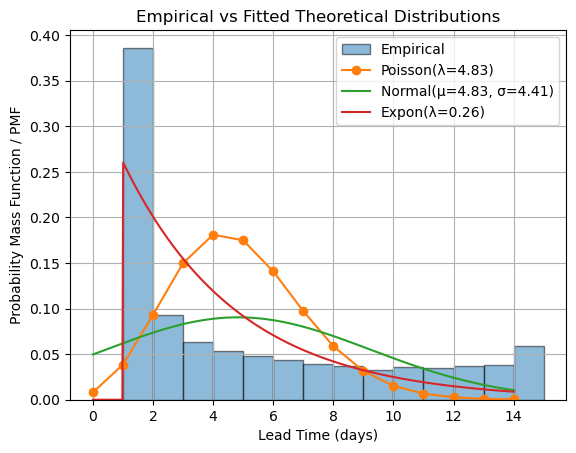

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Load and clean data
lead_time = pd.read_csv('lead_time_data.csv')
lead_time = pd.to_numeric(lead_time['lead_time_days'], errors='coerce').dropna().astype(int)

# Plot the data 
x_vals = np.arange(0, max(lead_time) + 1)
x_vals_cont = np.linspace(0, max(lead_time), 500)

# Plot histogram (empirical distribution)
plt.hist(lead_time, bins=range(0, max(lead_time) + 2), density=True, alpha=0.5, edgecolor='black', label='Empirical')

# Estimate lambda for Poisson
lambda_est = np.mean(lead_time)
plt.plot(x_vals, stats.poisson.pmf(x_vals, mu=lambda_est), marker='o', linestyle='-', label=f'Poisson(λ={lambda_est:.2f})')

# plot Normal distribution
mu, sigma = stats.norm.fit(lead_time)
plt.plot(x_vals_cont, stats.norm.pdf(x_vals_cont, mu, sigma), label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')

# plot Exponential distribution
loc_exp, scale_exp = stats.expon.fit(lead_time)
plt.plot(x_vals_cont, stats.expon.pdf(x_vals_cont, loc=loc_exp, scale=scale_exp), label=f'Expon(λ={1/scale_exp:.2f})')

plt.xlabel("Lead Time (days)")
plt.ylabel("Probability Mass Function / PMF")
plt.title("Empirical vs Fitted Theoretical Distributions")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
from scipy.stats import poisson, norm, expon, chisquare

# Observed frequencies
observed_counts = lead_time.value_counts().sort_index()
data = lead_time.values
n = len(data)

# Poisson Distribution Test
lambda_est = np.mean(data)
x_vals = observed_counts.index
expected_poisson = poisson.pmf(x_vals, mu=lambda_est) * n
expected_poisson *= observed_counts.sum() / expected_poisson.sum()

chi_stat_pois, p_val_pois = chisquare(f_obs=observed_counts, f_exp=expected_poisson)

# Bin data for continuous distributions
bins = np.arange(min(data), max(data) + 2)  
hist_counts, bin_edges = np.histogram(data, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Normal Distribution Test
mu, sigma = np.mean(data), np.std(data)
expected_normal = norm.pdf(bin_centers, loc=mu, scale=sigma) * n * np.diff(bins)
expected_normal *= hist_counts.sum() / expected_normal.sum() 
chi_stat_norm, p_val_norm = chisquare(f_obs=hist_counts, f_exp=expected_normal)

# Exponential Distribution Test
loc, scale = expon.fit(data, floc=0)
expected_expon = expon.pdf(bin_centers, loc=loc, scale=scale) * n * np.diff(bins)
expected_expon *= hist_counts.sum() / expected_expon.sum()  # Normalize
chi_stat_expon, p_val_expon = chisquare(f_obs=hist_counts, f_exp=expected_expon)

# Print results
print("=== Chi-Square Goodness-of-Fit Tests ===")
print(f"Poisson: χ² = {chi_stat_pois:.4f}, p = {p_val_pois:.4f}")
print(" -> " + ("Fail to reject H0 (fits Poisson)" if p_val_pois > 0.05 else "Reject H0 (not Poisson)"))

print(f"Normal: χ² = {chi_stat_norm:.4f}, p = {p_val_norm:.4f}")
print(" -> " + ("Fail to reject H0 (fits Normal)" if p_val_norm > 0.05 else "Reject H0 (not Normal)"))

print(f"Exponential: χ² = {chi_stat_expon:.4f}, p = {p_val_expon:.4f}")
print(" -> " + ("Fail to reject H0 (fits Exponential)" if p_val_expon > 0.05 else "Reject H0 (not Exponential)"))

=== Chi-Square Goodness-of-Fit Tests ===
Poisson: χ² = 482859.0518, p = 0.0000
 -> Reject H0 (not Poisson)
Normal: χ² = 48798.0486, p = 0.0000
 -> Reject H0 (not Normal)
Exponential: χ² = 16087.1456, p = 0.0000
 -> Reject H0 (not Exponential)


##### Our data does not follow anything of the main theoretical distribution above, I will use the empirical distribution 
##### and to successfully represent the distribution of the data above i will be using the piece wise method. 

### 2b. Using the piecewise approach to construct Lead time distribution.

##### Our data shows that 1 lead days stands separaate from the others so I will create a bin for 1 and then a bin for the others 

In [42]:
# --- Lead time binning and probability calculation ---
lead_time_bin1 = [v for v in lead_time.values if v == 1]
lead_time_bin2 = [v for v in lead_time.values if v != 1]

# Frequencies
lead_time_bin1_prob = len(lead_time_bin1) / len(lead_time)
lead_time_bin2_prob = len(lead_time_bin2) / len(lead_time)

# Simulation function 
def simulate_lead_time(n_samples,seed = 42):
    np.random.seed(seed)
    samples = []
    for _ in range(n_samples):
        if np.random.rand() < lead_time_bin1_prob:
            samples.append(1)
        else:
            samples.append(np.random.randint(2, 16))  # inclusive of 2 to 15
    return samples


##### Now we have two bins, looking at our histogram above its valid to assume that both bins lead_time_days(1) and lead_time_days(2-15) follows
##### a unifrom distribution. 

### 3a. Testing the ROP policy

##### Next, I will test an ROP policy and then estimate the unit short and units held.   





In [43]:
simulated_demand = [demand for simulated_demand_list in sim_demand for demand in simulated_demand_list] 

simulated_lead_times = simulate_lead_time(10000) 

reorder_point = 31500000

Item_selling_cost = 133.50

Item_purchasing_cost = 94.50

Ann_hold_rate = 0.20

stockout_cost = Item_selling_cost - Item_purchasing_cost 


def generate_simulation_table(rop, simulated_demand, simulated_lead_times, stockout_cost):
    sim_demand = []
    sim_lead_time = []
    units_held_list = []
    units_short_list = []
    holding_cost_list = []
    stockout_cost_list = []
    Total_cost_list = []

    n_periods = len(simulated_demand)
    for i in range(n_periods):
        demand = simulated_demand[i]
        lead_time = simulated_lead_times[i]

        sim_demand.append(demand)
        sim_lead_time.append(lead_time)

        units_held = max(rop - demand, 0)
        units_short = max(demand - rop, 0)

        units_held_list.append(units_held)
        units_short_list.append(units_short)

        holding_cost_this_period = (
            float(units_held) * (Item_purchasing_cost * Ann_hold_rate) * (lead_time / 365)
        )
        holding_cost_list.append(holding_cost_this_period)

        stock_out_cost_this_period = float(units_short) * stockout_cost


        stockout_cost_list.append(stock_out_cost_this_period)
        total_cost = holding_cost_this_period + stock_out_cost_this_period
        
        Total_cost_list.append(total_cost)

    return pd.DataFrame({
        'Simulated Demand': sim_demand,
        'Lead Time': sim_lead_time,
        'Units Held': units_held_list,
        'Units Short': units_short_list,
        'Holding Cost': holding_cost_list,
        'Stockout Cost': stockout_cost_list,
        'Total cost': Total_cost_list
    })

sim_data = generate_simulation_table(reorder_point, simulated_demand, simulated_lead_times, stockout_cost)
sim_data.head()

,Simulated Demand,Lead Time,Units Held,Units Short,Holding Cost,Stockout Cost,Total cost
0,1.752084e+07,1,1.397916e+07,0,7.238523e+05,0.0,7.238523e+05
1,1.501673e+07,12,1.648327e+07,0,1.024220e+07,0.0,1.024220e+07
2,1.804956e+07,6,1.345044e+07,0,4.178848e+06,0.0,4.178848e+06
3,2.083467e+07,1,1.066533e+07,0,5.522593e+05,0.0,5.522593e+05
4,1.496131e+07,1,1.653869e+07,0,8.563872e+05,0.0,8.563872e+05


##### The table above shows the results of testing an ROP policy of 31500000 units across various demand and lead time scenarios.
##### For instance, when demand is 2.056819e+07 and the lead time is 1 day, the resulting units held is 1.093181e+07 and units short is 0.0.
##### Next, I will calculate the average total cost across all simulated scenarios for this ROP, This will provide a more reliable 
##### Estimate of how the ROP policy performs over time.



In [44]:
average_total_cost = sim_data[['Total cost']].mean()
average_total_cost 

Total cost    4.547206e+06
dtype: float64

##### With an ROP of 3.15e+07 we have a total cost of 6.02e+06 estimated across 10000 simulated scenarios 